In [1]:
cd /root/edsr/BSRGAN_py

/root/edsr/BSRGAN_py


In [2]:
import os
from PIL import Image
import random
import PIL
import numbers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from utils.utils_blindsr import *
from utils import utils_image as util
from torchvision import transforms

class SRDataset(Dataset):

    def __init__(self, data_path):
        """

        :参数 data_path: 图片文件夹路径
        """

        self.data_path = data_path
        self.images_path = []

        # # 读取图像路径
        # for name in os.listdir(self.data_path):
        #     self.images_path.append(os.path.join(self.data_path, name))
        # 遍历目录,收集所有图像文件的路径
        for root, dirs, files in os.walk(self.data_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.images_path.append(os.path.join(root, file))

        self.pre_trans=transforms.Compose([
                                        transforms.ToTensor(),
                                        #transforms.Normalize(mean=[0.5],std=[0.5]),
                                        ])

    def __getitem__(self, i):
        # 读取图像文件路径
        img = Image.open(self.images_path[i], mode='r')
        img = img.convert('RGB')
        #img = uint2single(img)
        img = np.array(img, dtype=np.float32) / 255.0  # 将图像转换为单精度浮点数
        sf = 4  # 尺度
        img_lq, img_hq = degradation_bsrgan(img, sf=sf, lq_patchsize=72)

        lq_nearest = cv2.resize(util.single2uint(img_lq),
                                (int(sf * img_lq.shape[1]), int(sf * img_lq.shape[0])),
                                interpolation=0)
        img_hq = util.single2uint(img_hq)

        lq_nearest = self.pre_trans(lq_nearest)
        img_hq = self.pre_trans(img_hq)

        return lq_nearest, img_hq
        

    def __len__(self):
        return len(self.images_path)

torch.Size([3, 288, 288])
torch.Size([3, 288, 288])
<class 'numpy.ndarray'>
(288, 288, 3)
(288, 288, 3)


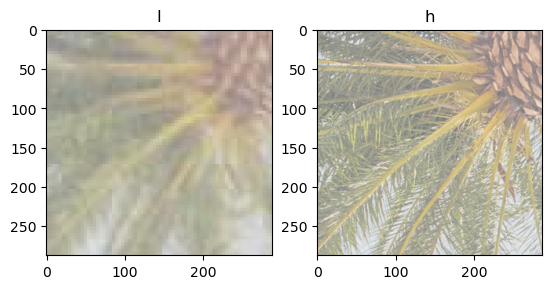

In [3]:
train_path='../train/DIV2K_train_HR'
ds=SRDataset(train_path)
                        
l,h=ds[2]

print(l.shape)
print(h.shape)

l=np.array(l)
h=np.array(h)
print(type(l))
l=l.transpose(2,1,0)
h=h.transpose(2,1,0)
print(l.shape)
print(h.shape)

plt.subplot(1, 2, 1)
plt.imshow(((l+1)/2))
plt.title('l')
plt.subplot(1, 2, 2)
plt.imshow(((h+1)/2))
plt.title('h')
plt.show()

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Function

class LayerNormFunction(Function):

    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.shape
        mu = x.mean(dim=1, keepdim=True)
        var = ((x - mu) ** 2).mean(dim=1, keepdim=True)
        y = (x - mu) / torch.sqrt(var + eps)
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps
        N, C, H, W = grad_output.shape
        y, var, weight = ctx.saved_tensors
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)
        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=[0, 2, 3]), grad_output.sum(dim=[0, 2, 3]), None


class LayerNorm2d(nn.Module):
    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.weight = nn.Parameter(torch.ones(channels))
        self.bias = nn.Parameter(torch.zeros(channels))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2


n_feat = 256
kernel_size = 3

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        
        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma


class EDSR(nn.Module):
    def __init__(self):
        super(EDSR, self).__init__()

        in_ch = 3
        num_blocks = 16
        c = 256
        self.conv1 = nn.Conv2d(in_ch, n_feat, kernel_size, padding=1)

        # nafblock
        self.body = self.make_layer(NAFBlock, num_blocks, c)
        # 扩大
        self.conv_up = nn.Conv2d(n_feat, n_feat * 4, kernel_size, padding=1)
        self.conv_out = nn.Conv2d(n_feat, in_ch, kernel_size, padding=1)
        # resblock
        # self.body = self.make_layer(_Res_Block, num_blocks)

        # 上采样
        self.upsample = nn.Sequential(self.conv_up, nn.PixelShuffle(2))

    # 32个naf块
    def make_layer(self, block, layers, c):
        naf_block = []
        for _ in range(layers):
            naf_block.append(block(c))
        return nn.Sequential(*naf_block)

    def forward(self, x):
        
        out = self.conv1(x)
        out = self.body(out)
        out = self.upsample(out)
        out = self.conv_out(out)

        return out

In [5]:
import os
from math import log10
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import warnings
import torch.nn.functional as F


if __name__ == '__main__':
    warnings.filterwarnings("ignore", category=Warning)  # 过滤报警信息

    train_path = '../DIV2K_valid_HR'
    test_path = '../non_test'

    # 学习参数
    checkpoint_dir = '../checkpoints'  # 模型保存路径
    # 定义保存的文件路径，包括文件名
    checkpoint_path = os.path.join(checkpoint_dir, 'edsr_NAF_non.pth')
    batch_size = 1
    start_epoch = 0
    epochs = 5000
    workers = 4
    lr = 1e-4

     # 检查GPU是否可用
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # 先前的psnr
    pre_psnr = 0

    try:
        model = torch.load(checkpoint_path)
        model = model.to(device)
        print('加载先前模型成功')
    except:
        print('未加载原有模型训练')
        model = EDSR()
        model = model.to(device)

    # 初始化优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

    # 采用L1损失函数
    criterion = nn.L1Loss()

    train_dataset = SRDataset(train_path)
    test_dataset = SRDataset(test_path)

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=workers,
                              )

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=workers,
                             )

    for epoch in range(start_epoch, epochs + 1):

        model.train()  # 训练模式
        train_loss = 0
        n_iter_train = len(train_loader)
        # print(n_iter_train)
        train_psnr = 0
        # 按批处理
        for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            
            lr_imgs = lr_imgs.to(torch.float32)
            sr_imgs = model(lr_imgs)
            
            # 匹配分辨率
            sr_imgs = F.interpolate(sr_imgs, size=hr_imgs.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(sr_imgs, hr_imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            psnr = 10 * log10(1 / loss.item())
            train_psnr += psnr

        epoch_loss_train = train_loss / n_iter_train
        train_psnr = train_psnr / n_iter_train

        print(f"Epoch {epoch}. Training loss: {epoch_loss_train} Train psnr {train_psnr} dB")

        model.eval()  # 测试模式
        test_loss = 0
        all_psnr = 0
        n_iter_test = len(test_loader)

        with torch.no_grad():
            for i, (lr_imgs, hr_imgs) in enumerate(test_loader):
                lr_imgs = lr_imgs.to(device)
                hr_imgs = hr_imgs.to(device)
                lr_imgs = lr_imgs.to(torch.float32)
                sr_imgs = model(lr_imgs)
                #匹配分辨率
                sr_imgs = F.interpolate(sr_imgs, size=hr_imgs.shape[2:], mode='bilinear', align_corners=False)
                loss = criterion(sr_imgs, hr_imgs)

                psnr = 10 * log10(1 / loss.item())
                all_psnr += psnr
                test_loss += loss.item()

        epoch_loss_test = test_loss / n_iter_test
        epoch_psnr = all_psnr / n_iter_test

        print(f"Epoch {epoch}. Testing loss: {epoch_loss_test} Test psnr{epoch_psnr} dB")

        if epoch_psnr > pre_psnr:
            torch.save(model, checkpoint_path)
            pre_psnr = epoch_psnr
            print('模型更新成功')

        scheduler.step()

Using device: cuda
未加载原有模型训练
Epoch 0. Training loss: 0.10991302566602826 Train psnr 10.076324920233935 dB
Epoch 0. Testing loss: 0.07595511972904205 Test psnr11.478594677028031 dB
模型更新成功
Epoch 1. Training loss: 0.08426040956750512 Train psnr 11.116018895376548 dB
Epoch 1. Testing loss: 0.08468518108129501 Test psnr10.831050653665589 dB
Epoch 2. Training loss: 0.08432985041290522 Train psnr 11.25002144770697 dB
Epoch 2. Testing loss: 0.09502549991011619 Test psnr10.73337428693657 dB
Epoch 3. Training loss: 0.07632070949301123 Train psnr 11.651299002913657 dB
Epoch 3. Testing loss: 0.0848903238773346 Test psnr10.877804949306398 dB
Epoch 4. Training loss: 0.08184517566114664 Train psnr 11.286027608220568 dB
Epoch 4. Testing loss: 0.1043338157236576 Test psnr10.115956048834821 dB
Epoch 5. Training loss: 0.07410751444287599 Train psnr 11.70592078376989 dB
Epoch 5. Testing loss: 0.08724613264203071 Test psnr10.91018566907204 dB
Epoch 6. Training loss: 0.07644882509484888 Train psnr 11.665215

KeyboardInterrupt: 

Using device: cuda


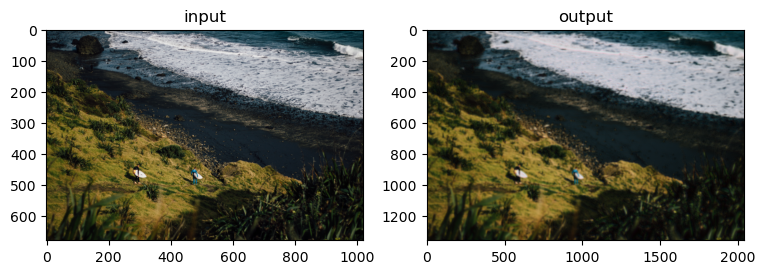

In [7]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import matplotlib.pyplot as plt


# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

imgO = Image.open('../0811x2.png').convert("RGB")  # 选择自己图片的路径

transform = transforms.Compose([
    transforms.ToTensor(),
])

# img = input_transform(imgO).unsqueeze(0).to(device)
img = transform(imgO).unsqueeze(0).to(device)  # 将图像移到GPU

# 导入模型
net = torch.load("../checkpoints/edsr_NAF_non.pth").to(device)  # 将模型移到GPU
net.eval()  # 设置模型为评估模式

with torch.no_grad():  # 不计算梯度
    source = net(img)[0, :, :, :]

source = source.cpu().detach().numpy()  # 转为numpy并移到CPU
source = source.transpose((1, 2, 0))  # 切换形状
source = np.clip(source, 0, 1)  # 修正图片
img = Image.fromarray(np.uint8(source * 255))

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(imgO)
plt.title('input')
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('output')
plt.show()

img.save('../result_NAF_non.png')
